# PIMA diabetes Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import session_info

from jmspack.utils import (apply_scaling,
                           JmsColors
                          )

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from sklearn.model_selection import (GridSearchCV, 
                                     RepeatedStratifiedKFold, 
                                     cross_val_score, 
                                     cross_validate, 
                                     train_test_split, 
                                     KFold)
from sklearn.feature_selection import RFE
from sklearn.metrics import (confusion_matrix, 
                             roc_curve, 
                             auc)
from imblearn.over_sampling import (SMOTE, 
                                    SVMSMOTE,
                                   KMeansSMOTE)
import shap

In [2]:
# init the JS visualization code
shap.initjs()

In [3]:
session_info.show(req_file_name="pima-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

In [4]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [5]:
df = pd.read_csv("diabetes.csv")

In [6]:
display(df.head()), display(df.shape)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)

(None, None)

In [7]:
target = "Outcome"

## Mask 0 default values (seen in EDA)

In [8]:
mask_default_values=True

In [9]:
if mask_default_values:
    df = (df.drop([target, "Pregnancies"], axis=1)
           .replace(0, np.nan)
           .merge(df[[target, "Pregnancies"]], left_index=True, right_index=True)
          .dropna()
          .reset_index(drop=True)
         )

## Plot the amount of rows in each side of the target

#### Looks like the target is imbalanced so this needs to be taken into account

Amount in each outcome


0    262
1    130
Name: Outcome, dtype: int64

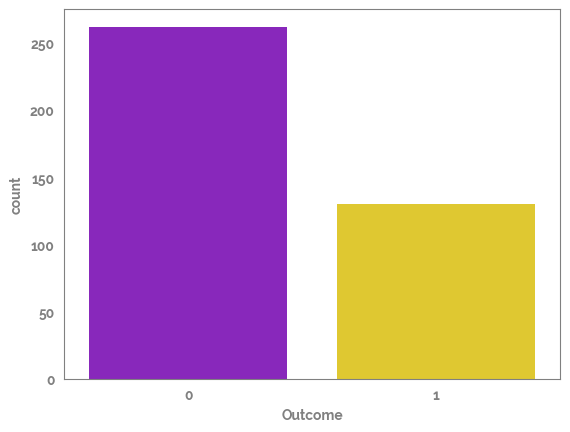

In [10]:
_ = sns.countplot(x=df[target])
print("Amount in each outcome")
df[target].value_counts()

## Resample data to correct for imbalance

In [11]:
resample_data=True

In [12]:
if resample_data:

    X = df.drop(target, axis=1)
    y = df[target]

    sm = KMeansSMOTE(sampling_strategy="not majority",
               random_state=42, 
               n_jobs=2)
    X_res, y_res = sm.fit_resample(X, y)

    print(X.shape, y.shape, X_res.shape, y_res.shape)

    df = pd.concat([X_res, y_res], axis=1)

(392, 8) (392,) (525, 8) (525,)


In [13]:
X = df.drop(target, axis=1)
y = df[target]

In [14]:
dict_of_models

[{'label': 'Logistic Regression', 'model': LogisticRegression()},
 {'label': 'Gradient Boosting', 'model': GradientBoostingClassifier()},
 {'label': 'K_Neighbors Classifier',
  'model': KNeighborsClassifier(n_neighbors=3)},
 {'label': 'SVM Classifier (linear)',
  'model': SVC(C=0.025, kernel='linear', probability=True)},
 {'label': 'SVM Classifier (Radial Basis Function; RBF)',
  'model': SVC(C=1, gamma=2, probability=True)},
 {'label': 'Gaussian Process Classifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))},
 {'label': 'Decision Tree (depth=5)',
  'model': DecisionTreeClassifier(max_depth=5)},
 {'label': 'Random Forest Classifier(depth=5)',
  'model': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)},
 {'label': 'Multilayer Perceptron (MLP) Classifier',
  'model': MLPClassifier(alpha=1, max_iter=1000)},
 {'label': 'AdaBoost Classifier', 'model': AdaBoostClassifier()},
 {'label': 'Naive Bayes (Gaussian) Classifier', 'model': GaussianNB

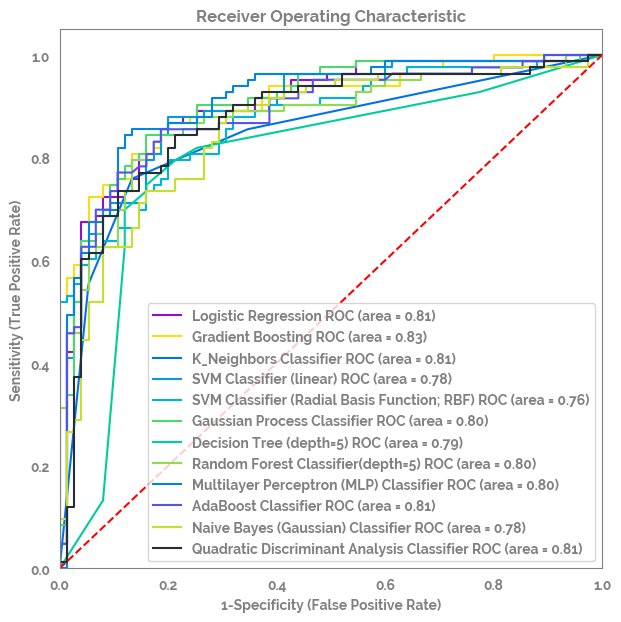

In [15]:
_ = multi_roc_auc_plot(X=X, 
                       y=y, 
                       models=dict_of_models)

In [16]:
n_features_to_select = 2 #[1, 2, 5, 10, 50, 100]
max_depth = [1, 2, 5, 10, 50, 100]
n_estimators = [1, 2, 5, 10, 50, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

In [17]:
# Instanciate Random Forest
# rf = RandomForestClassifier(random_state = 42,
#                             oob_score    = False) # use oob_score with many trees

rf = GradientBoostingClassifier(random_state = 42)

# Define params_dt
params_rf = {'max_depth'    : max_depth, 
#              'n_estimators' : n_estimators,
         'max_features' : ['log2', 'auto', 'sqrt'],
#          'criterion'    : ['gini', 'entropy'], #for RandomForestClassifier
           'criterion'    : ['friedman_mse', 'squared_error'] #for GradientBoostingClassifier
            }

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator  = rf,
                   param_grid = params_rf,
                   scoring    = 'roc_auc',
                   cv         = 3,
                   n_jobs     = -2)

# Optimize hyperparameter
_ = grid_dt.fit(X, y)

# Extract the best estimator
optimized_rf = grid_dt.best_estimator_

# Create the RFE with a optimized random forest
# rfe = RFE(estimator            = optimized_rf, 
#           n_features_to_select = n_features_to_select,
#           verbose              = 1)

rfe = RFE(estimator            = optimized_rf, 
      n_features_to_select = n_features_to_select,
      verbose              = 1)

# Fit the eliminator to the data
_ = rfe.fit(X, y)

# create dataframe with features ranking (high = dropped early on)
feature_ranking = pd.DataFrame(data  = dict(zip(X.columns, rfe.ranking_)) , 
                           index = np.arange(0, len(X.columns)))
feature_ranking = feature_ranking.loc[0,:].sort_values()

# create dataframe with feature selected
feature_selected = X.columns[rfe.support_].to_list()

# create dataframe with importances per feature
feature_importance = pd.Series(dict(zip(X.columns, optimized_rf.feature_importances_.round(2)))) 

max_depth = optimized_rf.get_params()['max_depth']
max_features = optimized_rf.get_params()['max_features']
criterion = optimized_rf.get_params()['criterion']

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


In [18]:
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

In [19]:
criterion, max_features, max_depth

('friedman_mse', 'sqrt', 5)

In [20]:
feature_importance_df

,feature,feature_importance
0,Glucose,0.39
1,Age,0.17
2,Insulin,0.14
3,BMI,0.10
4,DiabetesPedigreeFunction,0.09
5,SkinThickness,0.04
6,Pregnancies,0.04
7,BloodPressure,0.03


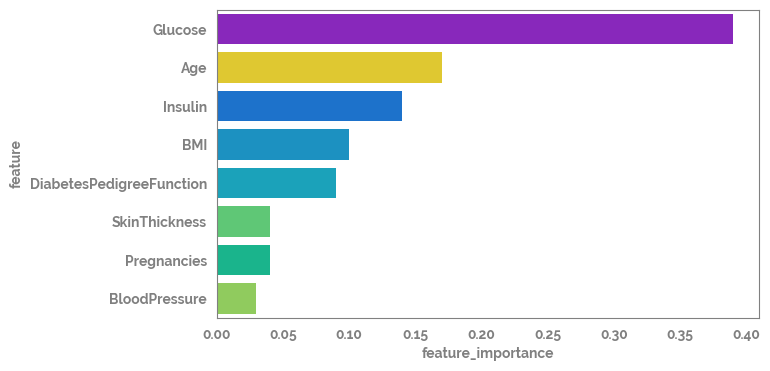

In [21]:
_ = plt.figure(figsize=(7, 4))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")
# _ = plt.savefig("images/feature_importances_diabetes_all.png", dpi=400, bbox_inches="tight")

In [22]:
explainer = shap.Explainer(optimized_rf)
shap_values = explainer(X)

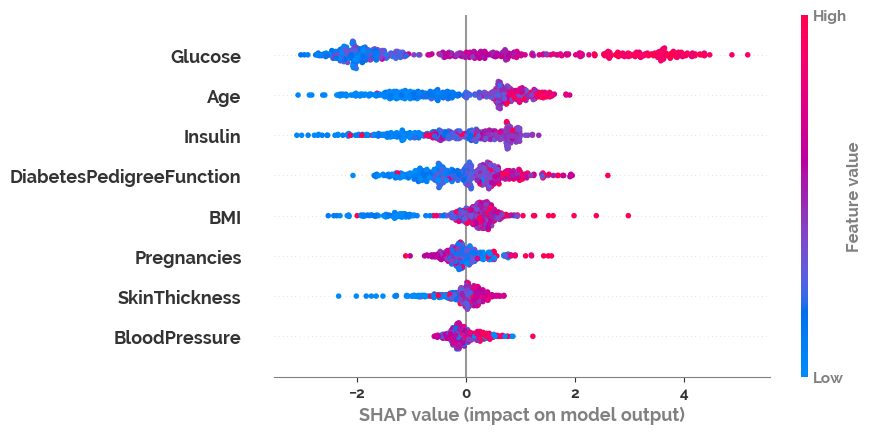

In [23]:
shap.plots.beeswarm(shap_values)

>Train: 0=201, 1=219, Test: 0=61, 1=44


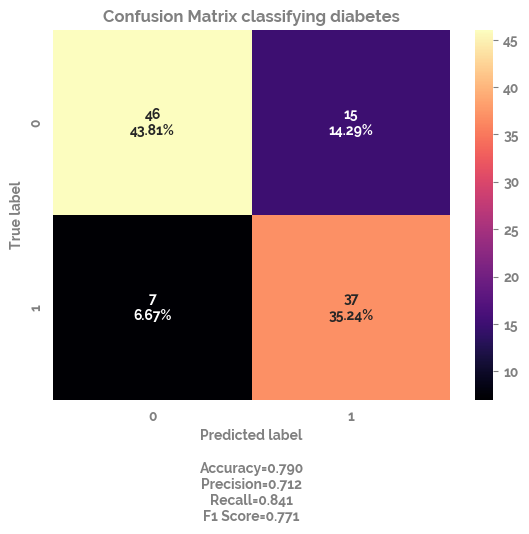

>Train: 0=210, 1=210, Test: 0=52, 1=53


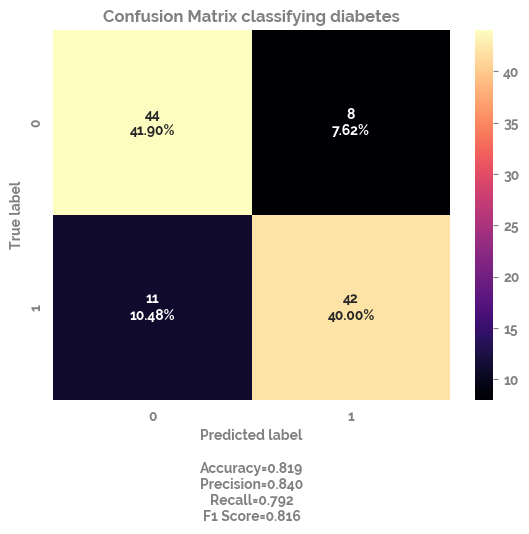

>Train: 0=215, 1=205, Test: 0=47, 1=58


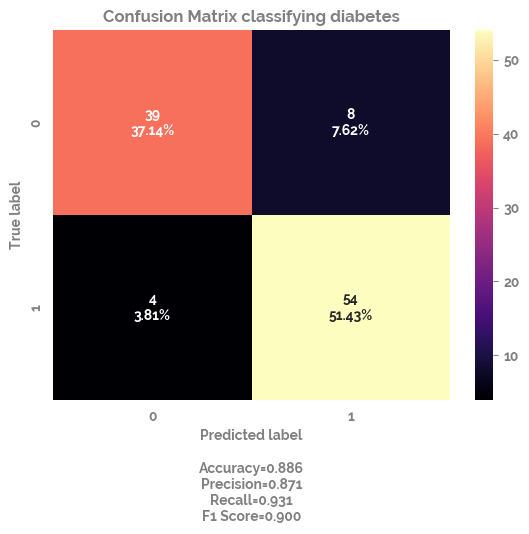

>Train: 0=206, 1=214, Test: 0=56, 1=49


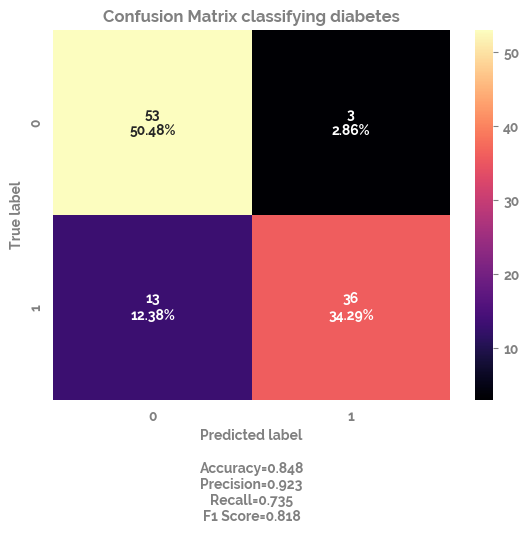

>Train: 0=216, 1=204, Test: 0=46, 1=59


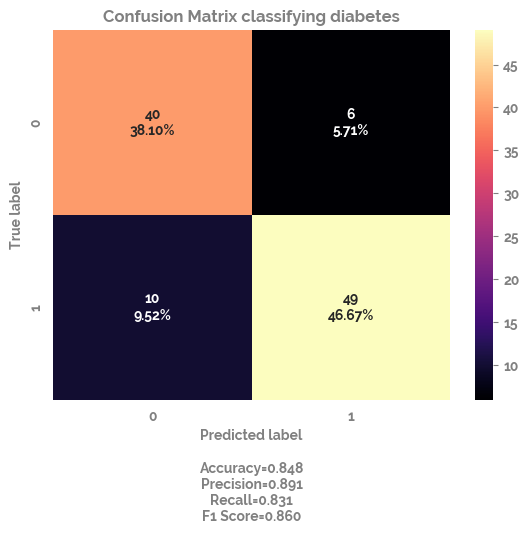

In [24]:
clf = optimized_rf

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title="Confusion Matrix classifying diabetes",
                     sum_stats=True,
                             cmap="magma")
    _ = plt.show()

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [26]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [27]:
scoring_list = ('accuracy',
 'balanced_accuracy',
 'f1',
 'f1_weighted',
 'precision',
 'precision_weighted',
 'recall',
 'recall_weighted',
 'roc_auc',
               )

In [28]:
tmp_out = cross_validate(optimized_rf, 
                         X, 
                         y, 
                         scoring=scoring_list, 
                         return_train_score=False, 
                         cv=cv, 
                         n_jobs=-1,
#                         fit_params={"sample_weight": sampling_weights} # fit_params is returning nans for some reason :/
                        )

In [29]:
pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).agg(["mean", "median", "std"]).round(3)

,test_accuracy,test_balanced_accuracy,test_f1,test_f1_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc
mean,0.838,0.838,0.836,0.838,0.854,0.843,0.824,0.838,0.922
median,0.846,0.846,0.846,0.846,0.857,0.851,0.830,0.846,0.926
std,0.053,0.053,0.054,0.054,0.070,0.053,0.076,0.053,0.038


In [30]:
cv_metrics_df = pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).melt(var_name="Metric")

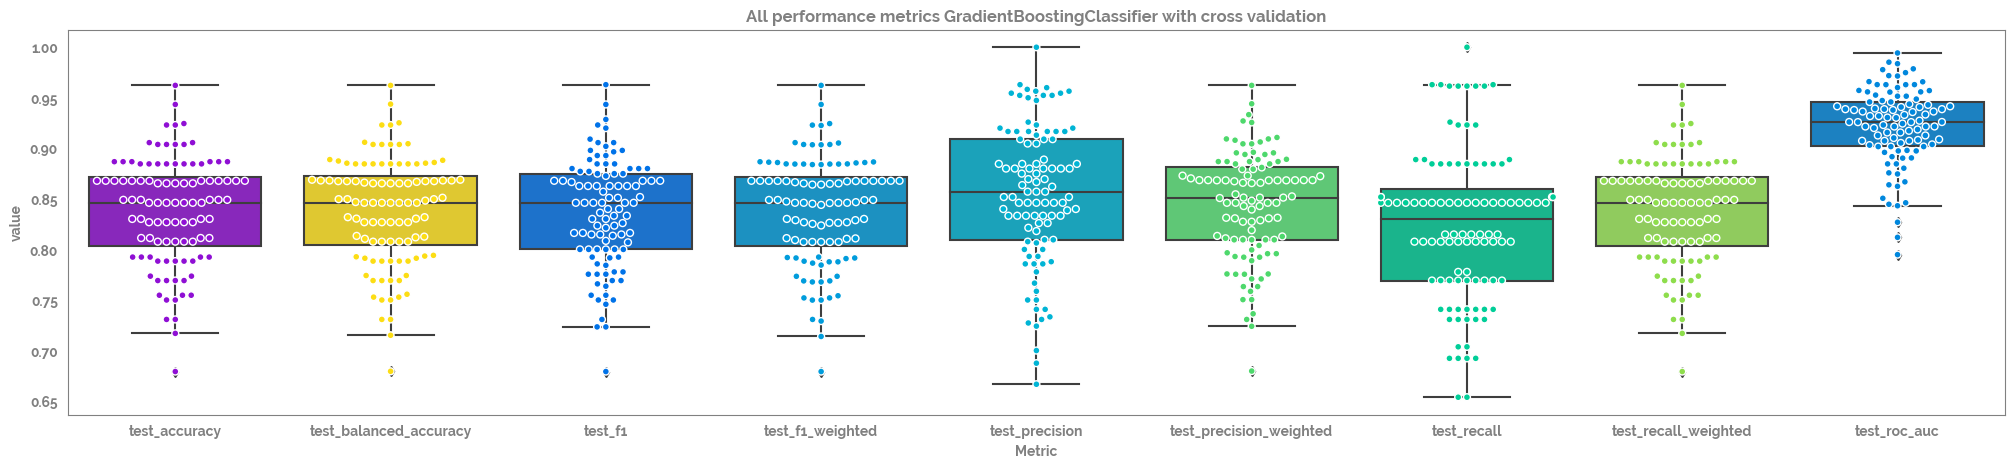

In [31]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = cv_metrics_df,
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = cv_metrics_df,
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title(f"All performance metrics {optimized_rf.__class__.__name__} with cross validation")

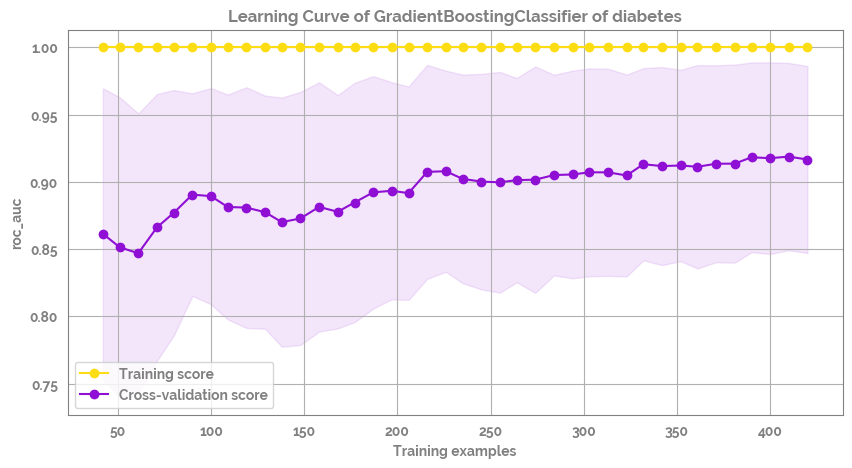

In [32]:
fig = plot_learning_curve(estimator=clf, 
                          title=f'Learning Curve of {optimized_rf.__class__.__name__} of diabetes',
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color=JmsColors.PURPLE, 
                          test_color=JmsColors.YELLOW, 
                          scoring='roc_auc',
                          ylim=None, 
                          cv=None, 
                          n_jobs=10, 
                          train_sizes=np.linspace(.1, 1.0, 40), 
                          figsize=(10,5))
# _ = plt.savefig(f"images/learning_curve_diabetes.png", dpi=400, bbox_inches="tight")

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# _ = optimized_rf.fit(X_train, y_train) # train the model
# y_pred = optimized_rf.predict(X_test) # predict the test data
# y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1] # predict the test data

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

# auc_score = auc(fpr,tpr)

# _ = plt.figure(figsize=(7,6))
# _ = plt.plot(fpr, tpr)
# _ = plt.scatter(fpr, tpr)
# _ = plt.annotate(xy=(0.9, 0.1), s=f"AUC: {round(auc_score,3)}", ha="center")
# _ = plt.plot([0,1], [0, 1], c="grey", ls="--")
# _ = plt.title(f'ROC curve {str(optimized_rf).split("(")[0]} - diabetes classification')
# _ = sns.despine()

0.9306676449009538
0.920479302832244
0.9369038884812912
0.9309090909090908
0.9216255442670538


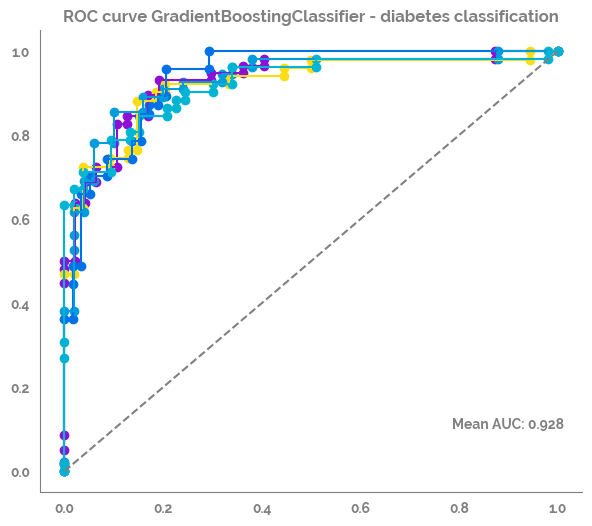

In [34]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
auc_score_list = list()
# enumerate the splits and summarize the distributions
_ = plt.figure(figsize=(7,6))
for train_ix, test_ix in kfold.split(X):
    # select rows
    X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
    y_train, y_test = y.loc[train_ix], y.loc[test_ix]

    _ = optimized_rf.fit(X_train, y_train) # train the model
    y_pred = optimized_rf.predict(X_test) # predict the test data
    y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1] # predict the test data

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

    auc_score = auc(fpr,tpr)
    print(auc_score)
    
    auc_score_list.append(auc_score)

    _ = plt.plot(fpr, tpr)
    _ = plt.scatter(fpr, tpr)

_ = plt.annotate(xy=(0.9, 0.1), text=f"Mean AUC: {round(np.mean(auc_score_list),3)}", ha="center")
_ = plt.plot([0,1], [0, 1], c="grey", ls="--")
_ = plt.title(f'ROC curve {optimized_rf.__class__.__name__} - diabetes classification')
_ = sns.despine()

In [35]:
X = df[feature_selected]
y = df[target]

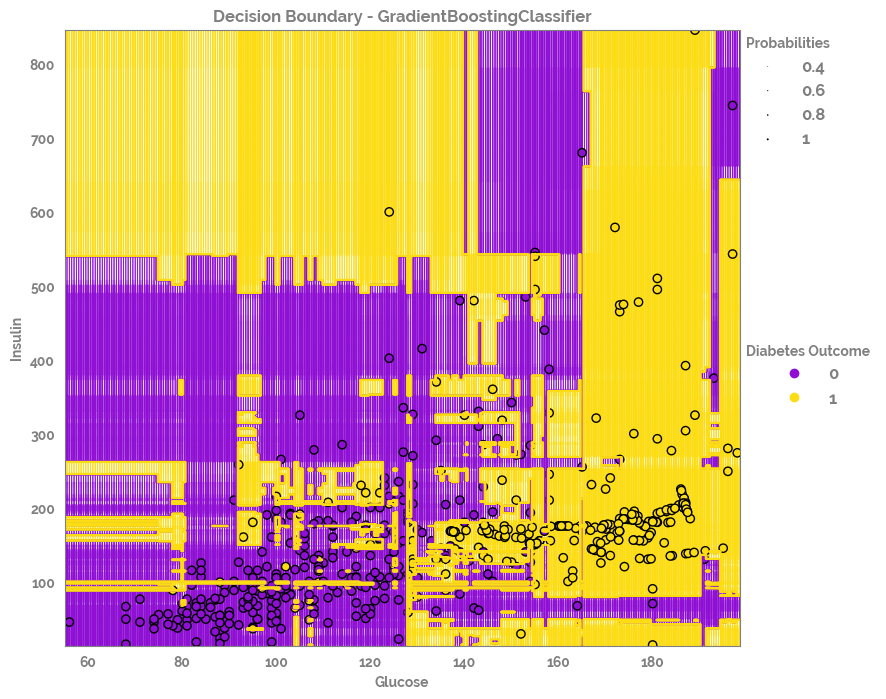

In [36]:
_ = plot_decision_boundary(X=X, 
                           y=y, 
                           clf=optimized_rf, 
                           title = f'Decision Boundary - {optimized_rf.__class__.__name__}', 
                           legend_title = "Diabetes Outcome",
                          h=0.5,
                          figsize=(10, 8))